In [1]:
import numpy as np
import glob
import os
import bs4
import tensorflow as tf
import matplotlib.pyplot as plt 
gpus = tf.config.experimental.list_physical_devices(device_type='GPU') #本地需要这样操作
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu ,True)



In [2]:
x_path=glob.glob('./dataset/images/*.jpg')


In [3]:
len(x_path)

7390

In [4]:
xml_path=glob.glob('./dataset/annotations/xmls/*.xml')



In [5]:
y_label= [x.split('\\')[-1].split('.')[0] for x in xml_path]
 
y_label[:5],len(y_label)

(['Abyssinian_1',
  'Abyssinian_10',
  'Abyssinian_100',
  'Abyssinian_101',
  'Abyssinian_102'],
 3686)

In [6]:
x_train_path=[path for path in x_path if path.split('\\')[-1].split('.')[0] in y_label ]

x_train_path[:5] ,len(x_train_path)

(['./dataset/images\\Abyssinian_1.jpg',
  './dataset/images\\Abyssinian_10.jpg',
  './dataset/images\\Abyssinian_100.jpg',
  './dataset/images\\Abyssinian_101.jpg',
  './dataset/images\\Abyssinian_102.jpg'],
 3686)

In [7]:
x_test_path=[path for path in x_path if path.split('\\')[-1].split('.')[0] not in y_label ]

len(x_test_path)



3704

In [8]:
#排序保证x和y对应
x_train_path.sort(key=lambda x:x.split('\\')[-1].split('.')[0])
xml_path.sort(key=lambda x:x.split('\\')[-1].split('.')[0])
y_label.sort()
x_train_path[:5],xml_path[:5]

(['./dataset/images\\Abyssinian_1.jpg',
  './dataset/images\\Abyssinian_10.jpg',
  './dataset/images\\Abyssinian_100.jpg',
  './dataset/images\\Abyssinian_101.jpg',
  './dataset/images\\Abyssinian_102.jpg'],
 ['./dataset/annotations/xmls\\Abyssinian_1.xml',
  './dataset/annotations/xmls\\Abyssinian_10.xml',
  './dataset/annotations/xmls\\Abyssinian_100.xml',
  './dataset/annotations/xmls\\Abyssinian_101.xml',
  './dataset/annotations/xmls\\Abyssinian_102.xml'])

In [9]:
#解析xml
def xml_to_label(path):
    xml=open(path,'r').read()
    soup=bs4.BeautifulSoup(xml,features='lxml')
    width =int(soup.width.text) 
    height =int(soup.height.text) 
    xmin =int(soup.xmin.text)
    xmax =int(soup.xmax.text)
    ymin =int(soup.ymin.text)
    ymax =int(soup.ymax.text)
    return [xmin/width,ymin/height,xmax/width,ymax/height]



In [10]:
y_pos=list(map(xml_to_label,xml_path))


In [11]:
y_pos[:3]


[[0.555, 0.18, 0.7083333333333334, 0.395],
 [0.192, 0.21, 0.768, 0.582],
 [0.383248730964467, 0.142, 0.850253807106599, 0.534]]

In [12]:
#zip相当与压缩  zip（*）相当于解压。
out1,out2,out3,out4=list(zip(*y_pos))
out1=np.array(out1)
out2=np.array(out2)
out3=np.array(out3)
out4=np.array(out4)

In [13]:
dataset_pos=tf.data.Dataset.from_tensor_slices((out1,out2,out3,out4))

In [14]:
next(iter(dataset_pos.take(1)))


(<tf.Tensor: shape=(), dtype=float64, numpy=0.555>,
 <tf.Tensor: shape=(), dtype=float64, numpy=0.18>,
 <tf.Tensor: shape=(), dtype=float64, numpy=0.7083333333333334>,
 <tf.Tensor: shape=(), dtype=float64, numpy=0.395>)

In [15]:
def load_preprosess_image(img_path):
    img_raw=tf.io.read_file(img_path)   
    img_tensor=tf.image.decode_jpeg(img_raw,channels=3)
    img_tensor=tf.image.resize(img_tensor,[224,224])
    img_tensor=tf.cast(img_tensor,tf.float32)
    img_tensor=img_tensor/224
    #img_tensor = 2*img_tensor-1
    return img_tensor
 

In [16]:
path_dataset=tf.data.Dataset.from_tensor_slices(x_train_path)
x_dataset=path_dataset.map(load_preprosess_image)
dataset=tf.data.Dataset.zip((x_dataset,dataset_pos))

In [17]:
data_count = len(x_train_path)
test_count = int(data_count*0.2)
train_count = data_count - test_count
BATCH_SIZE=32

In [18]:
dataset_train = dataset.skip(test_count)
dataset_test = dataset.take(test_count)


In [19]:
dataset_train=dataset_train.shuffle(train_count).repeat().batch(BATCH_SIZE)
dataset_test=dataset_test.repeat().batch(BATCH_SIZE)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


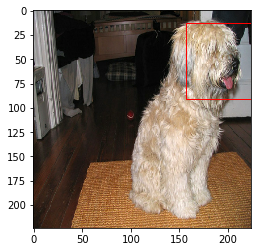

In [20]:
for x,pos in dataset_train.take(1):
    img_tensor=x[0]
    plt.imshow(img_tensor)
    out1,out2,out3,out4=pos
    xmin,ymin,xmax,ymax=out1[0].numpy()*224,out2[0].numpy()*224,out3[0].numpy()*224,out4[0].numpy()*224
    rect=plt.Rectangle((xmin,ymin),xmax-xmin,ymax-ymin,fill=False,color='red')
    ax=plt.gca()#获得当前子图 
    ax.add_patch(rect)


In [21]:
#创建定位模型
xception=tf.keras.applications.Xception(
    include_top=False,
    weights='imagenet',
    input_shape=(224,224,3)
)

In [22]:
inputs=tf.keras.layers.Input(shape=(224,224,3))
#等价于tf.keras.Input
x=xception(inputs)
x=tf.keras.layers.GlobalAveragePooling2D()(x)
x=tf.keras.layers.Dense(2049,activation='relu')(x)
x=tf.keras.layers.Dense(256,activation='relu')(x)
out1=tf.keras.layers.Dense(1)(x)
out2=tf.keras.layers.Dense(1)(x)
out3=tf.keras.layers.Dense(1)(x)
out4=tf.keras.layers.Dense(1)(x)
pred=[out1,out2,out3,out4]

In [23]:
model=tf.keras.models.Model( inputs=inputs,outputs=pred)
model.compile(
    tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss='mse',
    metrics=['mae']
)

In [24]:
epochs=50   


In [25]:
his=model.fit(
    dataset_train,
    epochs=epochs,
    steps_per_epoch=train_count//BATCH_SIZE,
    validation_data=dataset_test,
    validation_steps=test_count//BATCH_SIZE
)



Train for 92 steps, validate for 23 steps
Epoch 1/50
92/92 [==============================] - 75s 819ms/step - loss: 0.1117 - dense_2_loss: 0.0260 - dense_3_loss: 0.0133 - dense_4_loss: 0.0432 - dense_5_loss: 0.0292 - dense_2_mae: 0.1202 - dense_3_mae: 0.0889 - dense_4_mae: 0.1444 - dense_5_mae: 0.1282 - val_loss: 0.5131 - val_dense_2_loss: 0.1041 - val_dense_3_loss: 0.0213 - val_dense_4_loss: 0.2503 - val_dense_5_loss: 0.1374 - val_dense_2_mae: 0.2879 - val_dense_3_mae: 0.1184 - val_dense_4_mae: 0.4644 - val_dense_5_mae: 0.3391

In [26]:
his.history

{'loss': [0.1116968386442117,
  0.03180562168278772,
  0.017441066508383854,
  0.013352566211403388,
  0.010634887533302865,
  0.010286417384834393,
  0.008663587755543867,
  0.00795788483177919,
  0.007834316367971833,
  0.006408691221503946,
  0.007763502393019102,
  0.009139196314525021,
  0.007375614003926192,
  0.005972097417764851,
  0.0055971526282677505,
  0.004902191329798054,
  0.005131447625741282,
  0.004418361971266163,
  0.004190208030986073,
  0.0035141578586974547,
  0.0037709089975459906,
  0.0039071433661181645,
  0.003892224512326167,
  0.0039652785471053385,
  0.003630025422392899,
  0.003649036354466301,
  0.003150884403705435,
  0.0027505679172463715,
  0.0027179741964969057,
  0.0031407309465778426,
  0.002776130430309264,
  0.0025601103995501508,
  0.0027183166745564213,
  0.00222324198251084,
  0.002156368732634608,
  0.002534152787436893,
  0.0019393679160756342,
  0.0021285583339783402,
  0.0022089433446324065,
  0.0022241412396239034,
  0.0019463195330109043

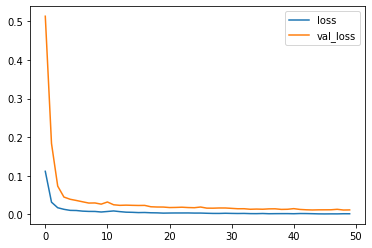

In [27]:
plt.plot(his.epoch, his.history.get('loss'),label='loss')
plt.plot(his.epoch, his.history.get('val_loss'),label='val_loss')
plt.legend()

 


In [29]:
model.save('./model/detect_v1.h5')

In [30]:
new_model=tf.keras.models.load_model('./model/detect_v1.h5')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


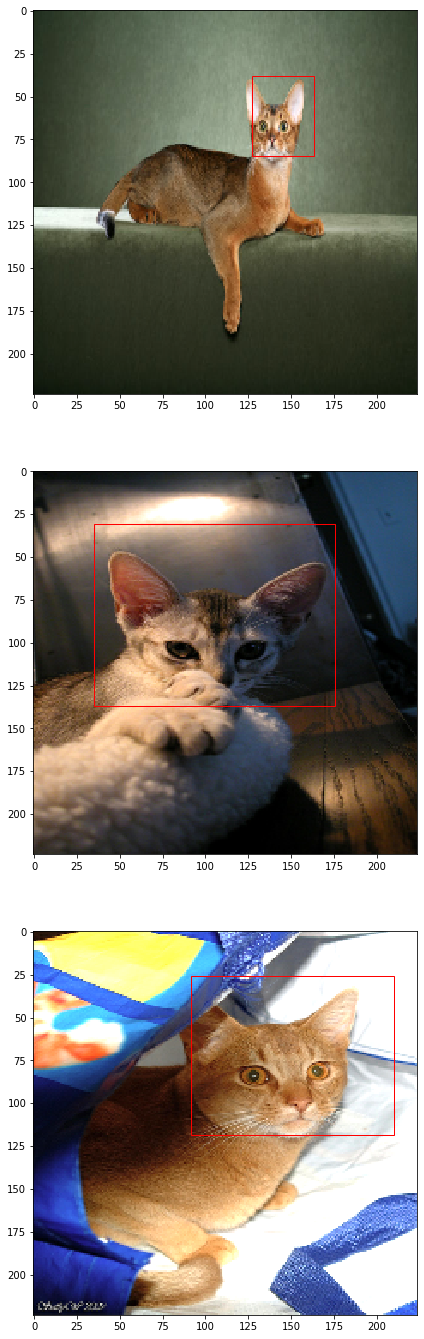

In [36]:
plt.figure(figsize=(8,24))
for x,_ in dataset_test.take(1):
    out1,out2,out3,out4=new_model.predict(x)

    for i in range(3):
        plt.subplot(3,1,i+1)
        img_tensor=x[i]
        plt.imshow(img_tensor)
        xmin,ymin,xmax,ymax=out1[i]*224,out2[i]*224,out3[i]*224,out4[i]*224
        rect=plt.Rectangle((xmin,ymin),xmax-xmin,ymax-ymin,fill=False,color='red')
        ax=plt.gca()#获得当前子图 
        ax.add_patch(rect)